# Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

`Important`: Because for 2017 version of COCO there is no test set with annotations. So I will used the val2017 set. This is ok, because those images wasn't used for training, so the model has never seen those images.

In [30]:
# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

import sys
#sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the testing images.
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224), # smaller edge of image resized to 256    
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test',
                         batch_size=1
                         )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

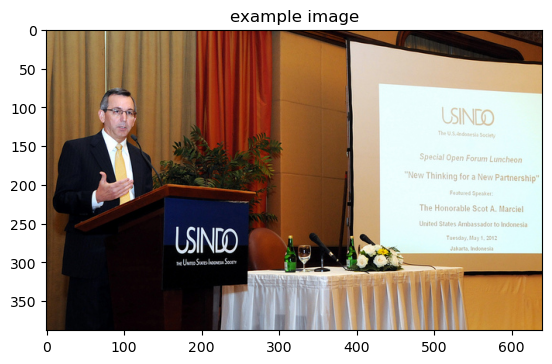

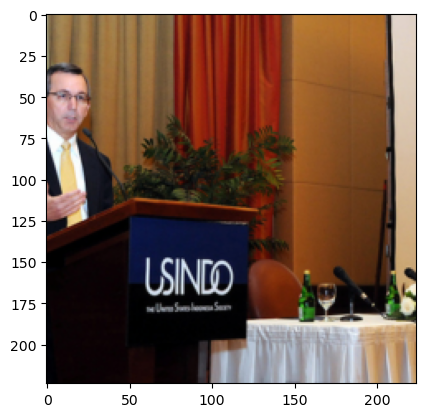

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

# Define reverse normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def show_transformed_image(tensor_image):
    # Reverse the normalization
    image = inv_normalize(tensor_image)

    # Convert to numpy and permute dimensions to [H, W, C] for matplotlib
    image = image.permute(1, 2, 0).cpu().numpy()

    # Clip pixel values to the range [0, 1] to ensure valid display
    image = image.clip(0, 1)

    # Display the image
    plt.imshow(image)
    plt.axis('on')
    plt.show()

show_transformed_image(image.squeeze(0))

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [32]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [33]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderGRU

# Specify the saved models to load.
encoder_file = 'models/encoder-3.pkl' 
decoder_file = 'models/decoder-3.pkl'

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderGRU(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(encoder_file))
decoder.load_state_dict(torch.load(decoder_file))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_901637/1511526579.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_file))
/tmp/ipykernel_901637/1511526579.py:2

DecoderGRU(
  (embed): Embedding(11543, 256)
  (attention): Attention(
    (attn): Linear(in_features=768, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (gru): GRU(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=11543, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [37]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

print(f"shape of image: {image.shape}")
# Obtain the embedded image features.

with torch.no_grad():
    features = encoder(image).unsqueeze(1)

print(f"shape of features: {features.shape}")

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features.squeeze(1))
output = output.cpu().tolist()[0] # tensor comes as a batch of 1 element

print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

shape of image: torch.Size([1, 3, 224, 224])
shape of features: torch.Size([1, 1, 49, 256])
example output: [3, 114, 40, 3, 1412, 16, 1026, 36, 334, 40, 10, 125, 3, 2740, 12, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [44]:
# Complete the function.
def clean_sentence(output):

    # Convert the word indices to words and join to form the final caption
    caption = [
        data_loader.dataset.vocab.idx2word[idx]  # Convert tensor to integer
        for idx in output if idx != data_loader.dataset.vocab('<end>')
    ]

    return ' '.join(caption)

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [45]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a man in a suit and tie is standing in front of a microphone .


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [50]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features.squeeze(1))
    output = output.cpu().tolist()[0]
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

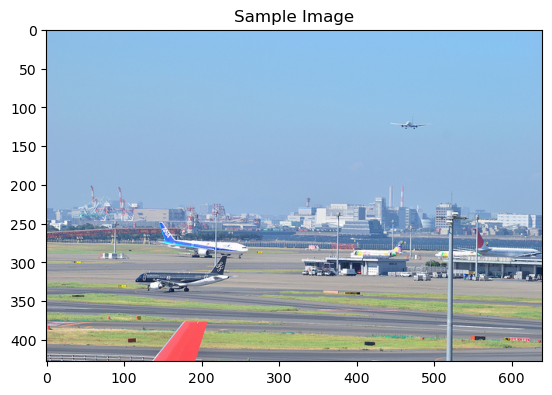

a large airplane flying over a runway with a city in the background .


In [51]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

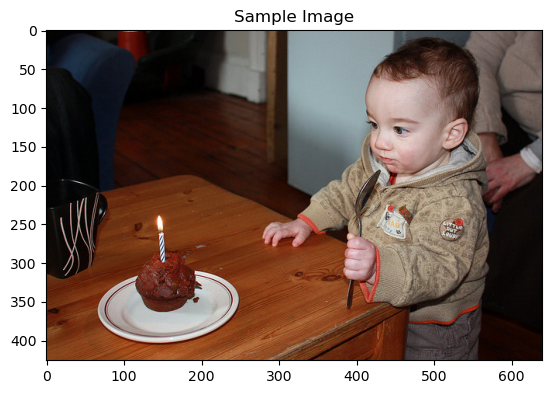

a little boy sitting at a table with a plate of food .


In [54]:
get_prediction()

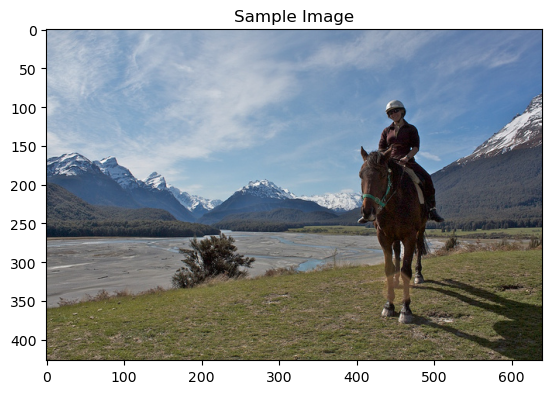

a man riding a horse on a lush green field .


In [55]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

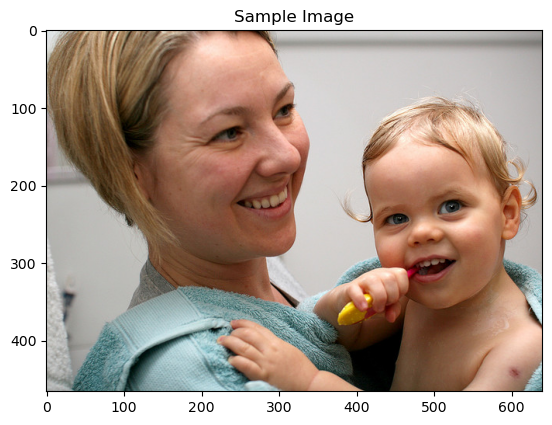

a young boy is eating a piece of food .


In [57]:
get_prediction()

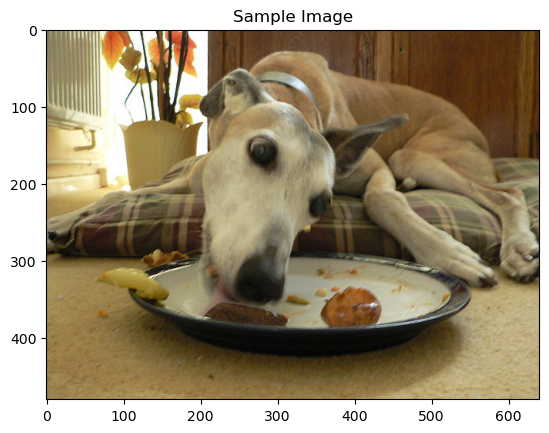

a dog laying on a plate with a dog laying on it 's side .


In [59]:
get_prediction()